# Model Analysis
The objective of this notebook is to develop predictive models to classify melanoma lessions in either benign or malignant. 

To evaluate the performance of each model, Train/Test split (80/20) and Cross-Validation (cv=10) will be used throughout the analysis. The nature of the project requires scoring methods different than accuracy, as mislabelling a benign melanoma is less fatal than mislabelling a malignant. For this reason, the following metrics will be used:
- Confusion Matrix, as a visual verification
- Recall, putting the enphasis on reducing False Negative

Additional metrics, such as AUC, were proposed by the Kaggle organizers. To understand the impact of our decissions, Receiver Operating Characteristic (ROC) curve will be obtained for verification purposes. 

This notebook will have the following sections:
- Data preparation
- Model selection, using three approaches: Metadata Only, Images Only, both sources
- Data optimisation, adding image augmentation techniques to minimise bias
- Model tuning, modifying architecture hyperparameters

## Import Packages

In [1]:
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt

sys.path.append("../Melanoma/")
import data_preprocessing
import image_preprocessing

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

## Data Preparation

In this section, tabular information is loaded and features are extracted for further postprocessing.

In [2]:
# Go to root if required
if os.getcwd().split("/")[-1] == "Explore":
    os.chdir("..")

# Define datasets locations
input_dcm_train = 'Datasets/dcm/train/'
input_dcm_filelist = os.listdir(input_dcm_train)
input_metadata_train = 'Datasets/train.csv'

# Load metadata datasets and remove NA and duplicates
md_train = pd.read_csv(input_metadata_train)                            \
    .pipe(lambda df: df.dropna(subset=["age_approx", "sex"], axis=0))   \
    .pipe(data_preprocessing.AgeOutlierAnalysis)                        \
    .pipe(data_preprocessing.RemoveDuplicateRecords)                    \
    .dropna(axis=0)                                                     \
    .set_index("image_name")                                            \
    .astype({
        "age_approx": 'float',
        "anatom_site_general_challenge": 'category',
        "diagnosis": 'category'
    })

md_train['age_approx'] = MinMaxScaler().fit_transform(md_train['age_approx'].values.reshape(-1,1))
md_train['IsMale'] = md_train.sex.apply(lambda x: 1 if x=="male" else 0)
md_train.head()

,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,IsMale
image_name,,,,,,,,
ISIC_2637011,IP_7279968,male,0.4375,head/neck,unknown,benign,0,1
ISIC_0015719,IP_3075186,female,0.4375,upper extremity,unknown,benign,0,0
ISIC_0052212,IP_2842074,female,0.5000,lower extremity,nevus,benign,0,0
ISIC_0068279,IP_6890425,female,0.4375,head/neck,unknown,benign,0,0
ISIC_0074268,IP_8723313,female,0.5625,upper extremity,unknown,benign,0,0


In [3]:
# Split dataset between features and labels
y = md_train.target
X = md_train.drop(["target", "benign_malignant", "patient_id", "sex", "diagnosis"], axis=1)
X = X.rename({'anatom_site_general_challenge': "Location"}, axis=1)
X = pd.get_dummies(X, columns=["Location"])
X = X.astype('float32')
X.head()

,age_approx,IsMale,Location_head/neck,Location_lower extremity,Location_oral/genital,Location_palms/soles,Location_torso,Location_upper extremity
image_name,,,,,,,,
ISIC_2637011,0.4375,1.0,1.0,0.0,0.0,0.0,0.0,0.0
ISIC_0015719,0.4375,0.0,0.0,0.0,0.0,0.0,0.0,1.0
ISIC_0052212,0.5000,0.0,0.0,1.0,0.0,0.0,0.0,0.0
ISIC_0068279,0.4375,0.0,1.0,0.0,0.0,0.0,0.0,0.0
ISIC_0074268,0.5625,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=14)

## Model Training
Now, we will train this dataset with various models:
- KNN
- Random Forest
- XGBoost

The model performance will be measured through Cross-validation using Recall and AUC and plotting both Confussion Matrix.

In [50]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

In [51]:
DM_model = DummyClassifier(strategy='most_frequent')
KNN_model = KNeighborsClassifier(n_neighbors=5)
RF_model = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=14)
XGB_model = XGBClassifier(n_estimators=1000, max_depth=10, random_state=14, use_label_encoder=False)

Establish the null score by using the dummy classifier

In [52]:
Null_model = cross_validate(DM_model, X_train, y_train, cv=5, scoring=["roc_auc","recall"])
Null_recall = sum(Null_model['test_recall'])/len(Null_model['test_recall'])
Null_AUC = sum(Null_model['test_roc_auc'])/len(Null_model['test_roc_auc'])

### Standard configuration

In [ ]:
# Cross-Validation
cv = StratifiedKFold(n_splits=5)

# KNN Variables
knn_conf_matrix = np.zeros((2,2))
knn_recall = []
knn_auc = []

# Random Forest Variables
rf_conf_matrix = np.zeros((2,2))
rf_recall = []
rf_auc = []

# XGBoost Variables
xg_conf_matrix = np.zeros((2,2))
xg_recall = []
xg_auc = []

for idx_train, idx_test in cv.split(X_train, y_train):
    # Obtain the split
    X, y = X_train.values[idx_train], y_train.values[idx_train]

    # Train both models 
    KNN_model.fit(X, y)
    RF_model.fit(X, y)
    XGB_model.fit(X, y)

    # Obtain prediction dataset
    X, y = X_train.values[idx_test], y_train.values[idx_test]

    # Predict both models
    KNN_pred = KNN_model.predict(X)
    RF_pred = RF_model.predict(X)
    XGB_pred = XGB_model.predict(X)

    # Store Confusion Matrix + Recall Score + AUC
    knn_conf_matrix += confusion_matrix(y, KNN_pred)
    rf_conf_matrix += confusion_matrix(y, RF_pred)
    xg_conf_matrix += confusion_matrix(y, XGB_pred)
    knn_recall.append(recall_score(y, KNN_pred))
    rf_recall.append(recall_score(y, RF_pred))
    xg_recall.append(recall_score(y, XGB_pred))
    knn_auc.append(roc_auc_score(y, KNN_pred))
    rf_auc.append(roc_auc_score(y, RF_pred))
    xg_auc.append(roc_auc_score(y, XGB_pred))

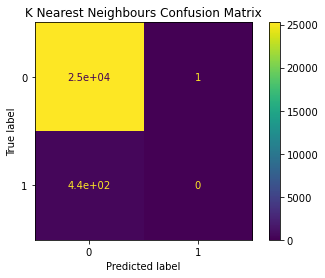

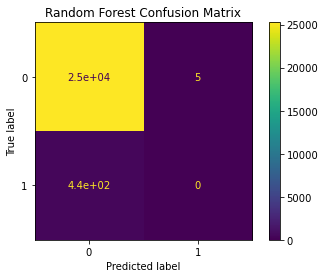

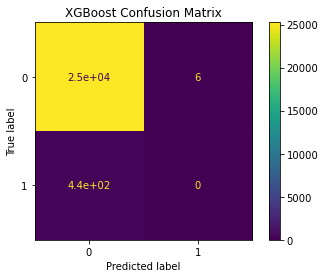

--------------
Recall Results
--------------
Null Hypothesis -> 0.0
KNN           -> 0.0
Random Forest -> 0.0
XGBoost       -> 0.0
--------------

--------------
AUC Results
--------------
Null Hypothesis -> 0.5
KNN           -> 0.4999802097763705
Random Forest -> 0.49990104104724287
XGBoost       -> 0.49988124690630853
--------------


In [ ]:
# Analyse the results
# Recall
knn_recall_av = sum(knn_recall)/len(knn_recall)
rf_recall_av = sum(rf_recall)/len(rf_recall)
xg_recall_av = sum(xg_recall)/len(xg_recall)
# AUC 
knn_auc_av = sum(knn_auc)/len(knn_auc)
rf_auc_av = sum(rf_auc)/len(rf_auc)
xg_auc_av = sum(xg_auc)/len(xg_auc)

# Display results
# Confusion Matrix
disp = ConfusionMatrixDisplay(knn_conf_matrix)
disp.plot()
plt.title("K Nearest Neighbours Confusion Matrix")
plt.show()

disp = ConfusionMatrixDisplay(rf_conf_matrix)
disp.plot()
plt.title("Random Forest Confusion Matrix")
plt.show()

disp = ConfusionMatrixDisplay(xg_conf_matrix)
disp.plot()
plt.title("XGBoost Confusion Matrix")
plt.show()

print("--------------")
print("Recall Results")
print("--------------")
print("Null Hypothesis -> " + str(Null_recall))
print("KNN           -> " + str(knn_recall_av))
print("Random Forest -> " + str(rf_recall_av))
print("XGBoost       -> " + str(xg_recall_av))
print("--------------")
print("")
print("--------------")
print("AUC Results")
print("--------------")
print("Null Hypothesis -> " + str(Null_AUC))
print("KNN           -> " + str(knn_auc_av))
print("Random Forest -> " + str(rf_auc_av))
print("XGBoost       -> " + str(xg_auc_av))
print("--------------")


It is clear that these models are highly influenced by the bias in the dataset.
Two alternative approaches will be explored:
- Tune XGBoost hyperparameters
- Try a simple NN

### Tune hyperparameters

Use different combination of hyperparameters to find best model performance

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

XGB_model = XGBClassifier(random_state=14, verbosity=0, use_label_encoder=False)
params = {
    "n_estimators": [10, 100, 1000],
    "learning_rate": [0.01, 0.1, 0.3, 0.5],
    "max_depth": [5, 10, 20, 50]
}
Grid_CV = GridSearchCV(XGB_model, param_grid=params, scoring='recall', n_jobs=-1, verbose=1)
Grid_CV.fit(X_train, y_train)


Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=14,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, use_label_encoder=Fa

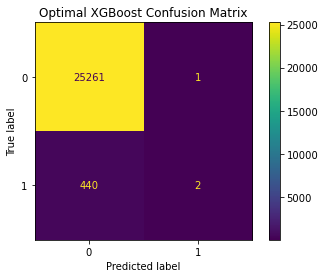

The best parameters found are -> {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 1000}
The best recall achieved are -> 0.0022727272727272726


In [ ]:
y_pred = Grid_CV.predict(X_train)
cm = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("Optimal XGBoost Confusion Matrix")
plt.show()


print("The best parameters found are -> " + str(Grid_CV.best_params_))
print("The best recall achieved are -> " + str(Grid_CV.best_score_))


The improvement obtained is marginal, obtaining two classification over the training dataset.
It is clear this is not the way forwards.

### Create simple Neural Network

Create simple 1-hidden stage Neural Network, using two hidden layers with 16 neurons each

In [5]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

print("Tensorflow version " + str(tf.__version__))

Tensorflow version 2.6.0


In [147]:
batch_size = 32
num_features = len(X.columns)
num_records = len(X)
dataset = tf.data.Dataset.from_tensor_slices((X, y))

In [148]:
def SplitTrainValTest(ds, ds_size=False, train_split=0.75, val_split=0.15, test_split=0.1, shuffle=False):

    assert (train_split + val_split + test_split) == 1, str(train_split + val_split + test_split)

    if not ds_size:
        ds_size = tf.data.experimental.cardinality(ds).numpy()

    if shuffle:
        ds.shuffle(10000)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [149]:
# Divide datasets into Train (75%), Val (15%), Test (10%)
ds_train, ds_val, ds_test = SplitTrainValTest(dataset)
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_val))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(24098, shape=(), dtype=int64)
tf.Tensor(4819, shape=(), dtype=int64)
tf.Tensor(3214, shape=(), dtype=int64)


In [152]:
ds_train = ds_train.batch(batch_size).prefetch(1)
ds_val = ds_val.batch(batch_size).prefetch(1)
ds_test = ds_test.batch(batch_size).prefetch(1)

In [153]:
SimpleNN = Sequential()
SimpleNN.add(Dense(16, activation='relu', input_shape=[num_features]))
SimpleNN.add(Dense(16, activation='relu'))
SimpleNN.add(Dense(1, activation='sigmoid'))
SimpleNN.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_53 (Dense)             (None, 16)                144       
_________________________________________________________________
dense_54 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_55 (Dense)             (None, 1)                 17        
Total params: 433
Trainable params: 433
Non-trainable params: 0
_________________________________________________________________


In [155]:
SimpleNN.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['Recall'])
SimpleNN.fit(ds_train, epochs=100, validation_data=ds_val, callbacks=EarlyStopping(monitor='val_recall', patience=5))

Epoch 1/100
754/754 [==============================] - 1s 873us/step - loss: 0.0908 - recall: 0.0000e+00 - val_loss: 0.1015 - val_recall: 0.0000e+00
Epoch 2/100
754/754 [==============================] - 1s 737us/step - loss: 0.0905 - recall: 0.0000e+00 - val_loss: 0.1011 - val_recall: 0.0000e+00
Epoch 3/100
754/754 [==============================] - 1s 727us/step - loss: 0.0902 - recall: 0.0000e+00 - val_loss: 0.1008 - val_recall: 0.0000e+00
Epoch 4/100
754/754 [==============================] - 1s 788us/step - loss: 0.0900 - recall: 0.0000e+00 - val_loss: 0.1005 - val_recall: 0.0000e+00
Epoch 5/100
754/754 [==============================] - 1s 730us/step - loss: 0.0898 - recall: 0.0000e+00 - val_loss: 0.1002 - val_recall: 0.0000e+00
Epoch 6/100
754/754 [==============================] - 1s 740us/step - loss: 0.0896 - recall: 0.0000e+00 - val_loss: 0.1000 - val_recall: 0.0000e+00


In [156]:
def RetrieveLabelsFromDataset(dataset):
    return np.concatenate([b for a, b in dataset], axis=0)

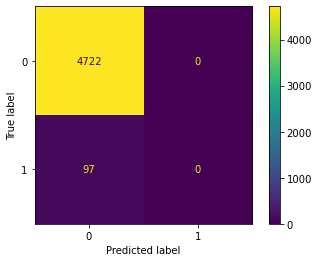

In [158]:
y_pred = np.round(SimpleNN.predict(ds_val))
y_true = RetrieveLabelsFromDataset(ds_val)
cm = confusion_matrix(y_pred=y_pred, y_true=y_true)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

The bias on this model towards the minority class is even higher. Next step - Try including *class_weight*

In [159]:
SimpleNN = Sequential()
SimpleNN.add(Dense(16, activation='relu', input_shape=[num_features]))
SimpleNN.add(Dense(16, activation='relu'))
SimpleNN.add(Dense(1, activation='sigmoid'))

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 16)                144       
_________________________________________________________________
dense_57 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_58 (Dense)             (None, 1)                 17        
Total params: 433
Trainable params: 433
Non-trainable params: 0
_________________________________________________________________


In [162]:
SimpleNN.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['Recall'])
SimpleNN.fit(ds_train, epochs=100, validation_data=ds_val, callbacks=EarlyStopping(monitor='val_recall', patience=5), class_weight = {0: 1., 1: 98.})

Epoch 1/100
754/754 [==============================] - 1s 939us/step - loss: 1.8129 - recall: 0.8735 - val_loss: 1.0672 - val_recall: 0.9485
Epoch 2/100
754/754 [==============================] - 1s 817us/step - loss: 1.6985 - recall: 0.9087 - val_loss: 1.0476 - val_recall: 0.9381
Epoch 3/100
754/754 [==============================] - 1s 773us/step - loss: 1.6862 - recall: 0.8946 - val_loss: 1.0290 - val_recall: 0.9278
Epoch 4/100
754/754 [==============================] - 1s 772us/step - loss: 1.6788 - recall: 0.8759 - val_loss: 1.0279 - val_recall: 0.9278
Epoch 5/100
754/754 [==============================] - 1s 775us/step - loss: 1.6748 - recall: 0.8665 - val_loss: 1.0234 - val_recall: 0.9072
Epoch 6/100
754/754 [==============================] - 1s 777us/step - loss: 1.6699 - recall: 0.8618 - val_loss: 1.0110 - val_recall: 0.8969
Epoch 7/100
754/754 [==============================] - 1s 784us/step - loss: 1.6662 - recall: 0.8525 - val_loss: 1.0124 - val_recall: 0.8969
Epoch 8/100
7

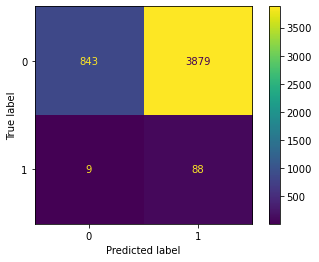

In [164]:
y_pred = np.round(SimpleNN.predict(ds_val))
y_true = RetrieveLabelsFromDataset(ds_val)
cm = confusion_matrix(y_pred=y_pred, y_true=y_true)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

As a final step, I will look at the influence of the metric, using AUC instead of recall - which is clearly skewed to the right

In [170]:
SimpleNN = Sequential()
SimpleNN.add(Dense(16, activation='relu', input_shape=[num_features]))
SimpleNN.add(Dense(16, activation='relu'))
SimpleNN.add(Dense(1, activation='sigmoid'))

In [171]:
SimpleNN.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['AUC'])
SimpleNN.fit(ds_train, epochs=100, validation_data=ds_val, callbacks=EarlyStopping(monitor='val_auc', patience=5), class_weight = {0: 1., 1: 80.})

Epoch 1/100
754/754 [==============================] - 1s 957us/step - loss: 1.6017 - auc: 0.5810 - val_loss: 0.9675 - val_auc: 0.6244
Epoch 2/100
754/754 [==============================] - 1s 794us/step - loss: 1.5662 - auc: 0.6302 - val_loss: 0.9393 - val_auc: 0.6413
Epoch 3/100
754/754 [==============================] - 1s 783us/step - loss: 1.5434 - auc: 0.6497 - val_loss: 0.9054 - val_auc: 0.6537
Epoch 4/100
754/754 [==============================] - 1s 786us/step - loss: 1.5293 - auc: 0.6606 - val_loss: 0.8951 - val_auc: 0.6587
Epoch 5/100
754/754 [==============================] - 1s 791us/step - loss: 1.5217 - auc: 0.6660 - val_loss: 0.8818 - val_auc: 0.6595
Epoch 6/100
754/754 [==============================] - 1s 799us/step - loss: 1.5156 - auc: 0.6701 - val_loss: 0.8742 - val_auc: 0.6603


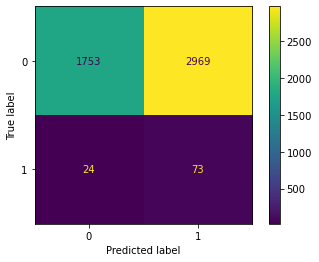

In [172]:
y_pred = np.round(SimpleNN.predict(ds_val))
y_true = RetrieveLabelsFromDataset(ds_val)
cm = confusion_matrix(y_pred=y_pred, y_true=y_true)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

# Using Images for classification

In [231]:
##########################################
###### CODE FROM TENSORFLOW ##############
##########################################
# https://www.tensorflow.org/guide/data  #
##########################################

def parse_image(filename, label_dict):
  # Obtain file index & label
  file = filename.split(os.sep)[-1].split('.')[0]
  label = label_dict.loc[file]
    
  # Load image from file
  image = tf.io.read_file(filename)
  image = tf.image.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)
  return image, label

def show(image, label):
  plt.figure()
  plt.imshow(image)
  plt.title((lambda x: 'Melanoma - Malignant' if x==1 else 'Melanoma - Benign')(label))
  plt.axis('off')

In [40]:
# Define datasets locations
input_jpeg_train = 'Datasets/jpeg/train_256'
img_label_df = md_train.target.sort_index()
filenames = md_train.index + '.jpg'

In [256]:
# Extract information from all images
images = []
labels = []
for file in input_jpeg_train:
    a, b = parse_image(file, img_label_df)
    images.append(a)
    labels.append(b)

# Load information inside a dataset - SUPER RAM Consuming > 46GB - Fit in computer but impossible to run in cloud
img_dataset = tf.data.Dataset.from_tensor_slices((images, labels))

The previous approach is too memory-hungry - load the entire dataset in memory will require too much memory. 
Better approach is to create a dataset and batch only few elements.

In [6]:
# Remove duplicated records based on previous analysis
# Need to run first data_preprocessing.RemoveDuplicateRecords
def RemoveDuplicatedImagesFromFolder(path, label_dict):
    files = os.listdir(path)
    valid_files = label_dict.index

    for file in files:
        if os.path.isfile(path + os.sep + file):
            if file.split('.')[0] in valid_files:
                pass
            else:
                os.remove(path + file)

# Create structure for TensorFlow to process the images
def CreateFolderStructTF(path, label_dict):
    # Create the directories if required
    try:
        os.makedirs(path + os.sep + 'Benign', exist_ok=False)
    except:
        pass

    try:
        os.makedirs(path + os.sep + 'Malignant', exist_ok=False)
    except:
        pass

    for file in label_dict.index.to_list():
        filename = path + os.sep + file + '.jpg'
        if os.path.isfile(filename):
            if label_dict.loc[file]==1:
                os.replace(filename, path + os.sep + 'Malignant' + os.sep + file + '.jpg')
            else:
                os.replace(filename, path + os.sep + 'Benign' + os.sep + file + '.jpg')
            
     

In [8]:
# Establish default parameters
input_jpeg_train = 'Datasets/jpeg/train_256'
img_label_df = md_train.target.sort_index()
image_height = 255
image_width = 255
image_channels = 3
batch_size = 32
num_classes = 2

# Remove duplicated images - if any
RemoveDuplicatedImagesFromFolder(input_jpeg_train, img_label_df)

# Create folder structure as requested by TF -> https://stackoverflow.com/questions/68449103/tf-keras-preprocessing-image-dataset-from-directory-value-error-no-images-found
CreateFolderStructTF(input_jpeg_train, img_label_df)

# Obtain training dataset
img_train_ds = tf.keras.utils.image_dataset_from_directory(
  input_jpeg_train,
  labels="inferred",
  # labels=img_label_df.to_list(),
  validation_split=0.2,
  subset="training",
  seed=14,
  label_mode='binary',
  image_size=(image_height,image_width),
  batch_size=batch_size)

# Obtain validation dataset
img_val_ds = tf.keras.utils.image_dataset_from_directory(
  input_jpeg_train,
  labels="inferred",
  # labels=img_label_df.to_list(),
  validation_split=0.2,
  subset="validation",
  seed=14,
  label_mode='binary',
  image_size=(image_height,image_width),
  batch_size=batch_size)

Found 32131 files belonging to 2 classes.
Using 25705 files for training.


2021-11-10 12:11:04.907977: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 32131 files belonging to 2 classes.
Using 6426 files for validation.


In [9]:
# Check that the classes are OK
class_names = img_train_ds.class_names
print(class_names)
for image_batch, labels_batch in img_train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

['Benign', 'Malignant']
(32, 255, 255, 3)
(32, 1)


2021-11-10 12:11:09.467335: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


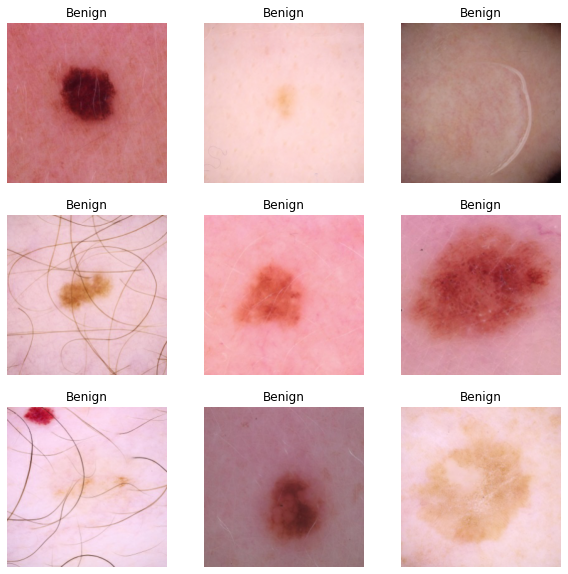

In [10]:
import matplotlib.pyplot as plt

# Plot some example images
plt.figure(figsize=(10, 10))
for images, labels in img_train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[int(labels[i])])
    plt.axis("off")

In [11]:
# Prefetch data for better performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = img_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = img_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
from keras.layers import Rescaling, Conv2D, MaxPooling2D, Flatten, Dense

CNN_custom_model = Sequential([
  Rescaling(1./255, input_shape=(image_height, image_width, 3)),
  Conv2D(16, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(1, activation='softmax')
])
CNN_custom_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 255, 255, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 255, 255, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 127, 127, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 63, 63, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 31, 31, 64)       

This is faaaaaaaar too many parameters to tune with only 25k, but we will give it a go just to try.

In [ ]:
CNN_custom_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['Recall', 'AUC'])
CNN_custom_model.fit(img_train_ds, epochs=10, validation_data=img_val_ds, callbacks=EarlyStopping(monitor='val_recall', patience=5), class_weight = {0: 1., 1: 80.})


# Pending Questions

- How am I going to merge the two datasets - metadata and images?